In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import KFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

In [2]:
# Download cleaned data from project github
url_application = "https://raw.githubusercontent.com/manish-cr/CS3244-credit-approval/master/data/application_cleaned.csv"

# Download the 2 & 3 labelled data from project github
test_data_2label_url = "https://raw.githubusercontent.com/manish-cr/CS3244-credit-approval/master/data/credit_cleaned_test_twolabels.csv"
test_data_3label_url = "https://raw.githubusercontent.com/manish-cr/CS3244-credit-approval/master/data/credit_cleaned_test_threelabels.csv"

train_data_2label_url = "https://raw.githubusercontent.com/manish-cr/CS3244-credit-approval/master/data/credit_cleaned_training_twolabels.csv"
train_data_3label_url = "https://raw.githubusercontent.com/manish-cr/CS3244-credit-approval/master/data/credit_cleaned_training_threelabels.csv"

In [3]:
# Train + Test data labels (2 label and 3 label versions)
train_data_2label = pd.read_csv(train_data_2label_url)
train_data_3label = pd.read_csv(train_data_3label_url)

test_data_2label = pd.read_csv(test_data_2label_url)
test_data_3label = pd.read_csv(test_data_3label_url)

# Cleaned data
application_df = pd.read_csv(url_application)

In [4]:
# Only the Label column is needed, ID is used as the key when merging the datasets
credit_train_2label = train_data_2label[['ID', 'Credit_Status']]
credit_train_3label = train_data_3label[['ID', 'Credit_Status']]

credit_test_2label = test_data_2label[['ID', 'Credit_Status']]
credit_test_3label = test_data_3label[['ID', 'Credit_Status']]

In [5]:
# Merging application and credit csv based on ID
train_2label_df = pd.merge(application_df, credit_train_2label, how="inner", on="ID").loc[:,'ID':]
test_2label_df = pd.merge(application_df, credit_test_2label, how="inner", on="ID").loc[:,'ID':]

train_3label_df = pd.merge(application_df, credit_train_3label, how="inner", on="ID").loc[:,'ID':]
test_3label_df = pd.merge(application_df, credit_test_3label, how="inner", on="ID").loc[:,'ID':]

In [6]:
# need to fix these dtype from int64 to categorical
columns_to_convert = ['FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']

# Convert the data type of the specified columns to object
train_2label_df[columns_to_convert] = train_2label_df[columns_to_convert].astype('object')
train_3label_df[columns_to_convert] = train_3label_df[columns_to_convert].astype('object')

test_2label_df[columns_to_convert] = test_2label_df[columns_to_convert].astype('object')
test_3label_df[columns_to_convert] = test_3label_df[columns_to_convert].astype('object')

In [7]:
# Separating the data into X and y
X_train_2label = train_2label_df.loc[:, "CODE_GENDER":"CNT_FAM_MEMBERS"]
y_train_2label = train_2label_df["Credit_Status"]

X_train_3label = train_3label_df.loc[:, "CODE_GENDER":"CNT_FAM_MEMBERS"]
y_train_3label = train_3label_df["Credit_Status"]

X_test_2label = test_2label_df.loc[:, "CODE_GENDER":"CNT_FAM_MEMBERS"]
y_test_2label = test_2label_df["Credit_Status"]

X_test_3label = test_3label_df.loc[:, "CODE_GENDER":"CNT_FAM_MEMBERS"]
y_test_3label = test_3label_df["Credit_Status"]

In [8]:
# Identifying the columns that are of type int64 and float64 (for train)
numeric_col = []
for names in X_train_2label.columns:
  if X_train_2label[names].dtypes in ['int64', 'float64']:
    numeric_col.append(names)

# Standardising the columns of type int64 and float64
features = X_train_2label[numeric_col]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
X_train_2label[numeric_col] = features

features = X_train_3label[numeric_col]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
X_train_3label[numeric_col] = features

# for test
features = X_test_2label[numeric_col]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
X_test_2label[numeric_col] = features

features = X_test_3label[numeric_col]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
X_test_3label[numeric_col] = features

In [9]:
# Identifying the columns that are of type object
categorical_col = []
for names in X_train_2label.columns:
  if X_train_2label[names].dtypes in ['object']:
    categorical_col.append(names)

## One Hot Encoding the categorical columns (train)
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit and transform the specified columns
encoded_columns = encoder.fit_transform(X_train_2label[categorical_col])

# Create a DataFrame from the one-hot encoded columns
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_col))

# Concatenate the one-hot encoded DataFrame with the original DataFrame
X_train_2label = pd.concat([X_train_2label, encoded_df], axis=1)
X_train_3label = pd.concat([X_train_3label, encoded_df], axis=1)

# Drop the original categorical columns if needed
X_train_2label = X_train_2label.drop(categorical_col, axis=1)
X_train_3label = X_train_3label.drop(categorical_col, axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [10]:
## One Hot Encoding the categorical columns (test)
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit and transform the specified columns
encoded_columns = encoder.fit_transform(X_test_2label[categorical_col])

# Create a DataFrame from the one-hot encoded columns
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_col))

# Concatenate the one-hot encoded DataFrame with the original DataFrame
X_test_2label = pd.concat([X_test_2label, encoded_df], axis=1)
X_test_3label = pd.concat([X_test_3label, encoded_df], axis=1)

# Drop the original categorical columns if needed
X_test_2label = X_test_2label.drop(categorical_col, axis=1)
X_test_3label = X_test_3label.drop(categorical_col, axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


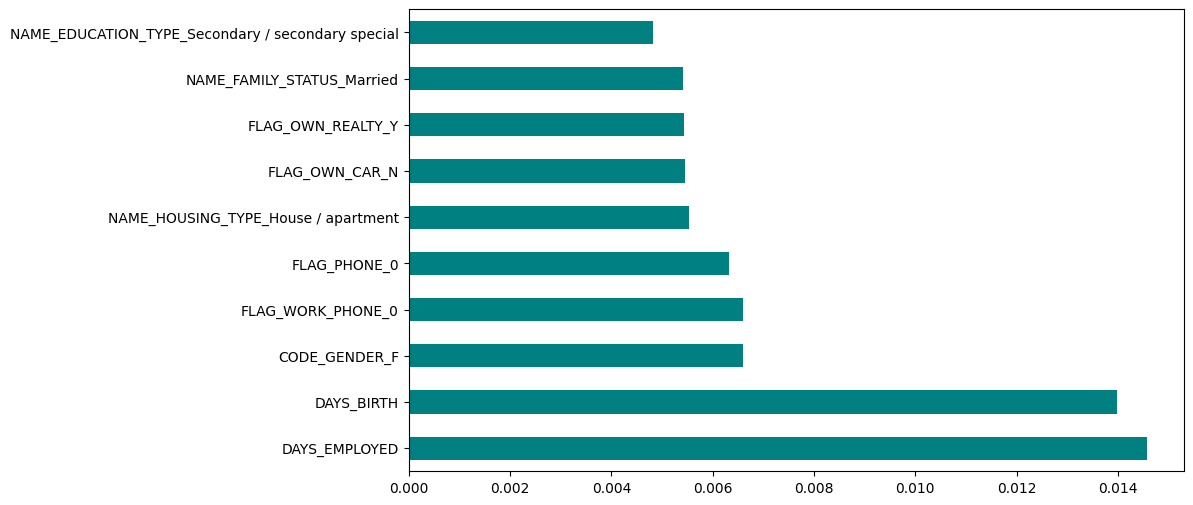

In [11]:
# Feature Selection by Filter method
# Information Gain
importances = mutual_info_classif(X_train_2label, y_train_2label)
feat_importances = pd.Series(importances, X_train_2label.columns)

# Select the top 10 features
top_10_feats = feat_importances.nlargest(10)

plt.figure(figsize=(10, 6))
top_10_feats.plot(kind='barh', color='teal')
plt.show()

In [12]:
# From here, we will use the top 10 features for the Neural Network Model
top_10 = top_10_feats.index.to_list()
print(top_10)

['DAYS_EMPLOYED', 'DAYS_BIRTH', 'CODE_GENDER_F', 'FLAG_WORK_PHONE_0', 'FLAG_PHONE_0', 'NAME_HOUSING_TYPE_House / apartment', 'FLAG_OWN_CAR_N', 'FLAG_OWN_REALTY_Y', 'NAME_FAMILY_STATUS_Married', 'NAME_EDUCATION_TYPE_Secondary / secondary special']


In [13]:
# Select only the top 10 features
X_train_2label_top_10 = X_train_2label.loc[:, top_10]
X_train_3label_top_10 = X_train_3label.loc[:, top_10]

X_test_2label_top_10 = X_test_2label.loc[:, top_10]
X_test_3label_top_10 = X_test_3label.loc[:, top_10]

In [14]:
# Checking shapes to make sure everything fits
# X_train.info() 10 cols
X_train_2label_top_10.shape,X_test_2label_top_10.shape,y_train_2label.shape,y_test_2label.shape

((29245, 10), (7212, 10), (29245,), (7212,))

In [15]:
# We will then test by 2 / 3 labels
# Starting with 2 labels
# Label encoding y_train and y_test

le = LabelEncoder()
le.fit(y_train_2label)
y_train_encoded = le.transform(y_train_2label)
y_test_encoded = le.transform(y_test_2label)

In [16]:
# Set random seed
tf.random.set_seed(0)

# 1. Create the model using the Sequential API
# Input Layer: number of features
# For hidden layer: the number of neurons should be in between the input data dimension and the output data dimension.
# Last layer: number of classes
model = keras.Sequential([layers.Dense(10, activation='relu'),
                          layers.Dense(6, activation='relu'),
                          layers.Dense(1, activation='sigmoid')])

# 2. Compile the model
model.compile(loss="binary_crossentropy",
              optimizer= "adam",
              metrics=["accuracy"])

# 3. Fit the model
model.fit(X_train_2label_top_10, y_train_encoded, epochs=5)

Epoch 1/5
914/914 [==============================] - 3s 2ms/step - loss: 0.1355 - accuracy: 0.9771
Epoch 2/5
914/914 [==============================] - 3s 3ms/step - loss: 0.1119 - accuracy: 0.9771
Epoch 3/5
914/914 [==============================] - 2s 3ms/step - loss: 0.1102 - accuracy: 0.9771
Epoch 4/5
914/914 [==============================] - 2s 2ms/step - loss: 0.1093 - accuracy: 0.9771
Epoch 5/5
914/914 [==============================] - 2s 2ms/step - loss: 0.1090 - accuracy: 0.9771


In [17]:
# Evaluate Model with test data
score_2label = model.evaluate(x=X_test_2label_top_10, y=y_test_encoded)
print("2-label Test loss:", score_2label[0])
print("2-label Test Accuracy: ", score_2label[1])

226/226 [==============================] - 1s 2ms/step - loss: 0.1166 - accuracy: 0.9753
2-label Test loss: 0.11656437814235687
2-label Test Accuracy:  0.9753189086914062


In [18]:
# Now 3 labels
# Label encoding y_train and y_test

le = LabelEncoder()
le.fit(y_train_3label)
y_train_encoded = le.transform(y_train_3label)
y_test_encoded = le.transform(y_test_3label)

In [19]:
# Set random seed
tf.random.set_seed(0)

# 1. Create the model using the Sequential API
# Input Layer: number of features
# For hidden layer: the number of neurons should be in between the input data dimension and the output data dimension.
# Last layer: number of classes
# sparse categorical crossentropy is appropriate for cases where the classes are mutually exclusive, meaning each sample belongs to only one class.
model = keras.Sequential([layers.Dense(10, activation='relu'),
                          layers.Dense(6, activation='relu'),
                          layers.Dense(3, activation='softmax')])

# 2. Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer= "adam",
              metrics=['sparse_categorical_accuracy'])

# 3. Fit the model
model.fit(X_train_3label_top_10, y_train_encoded, epochs=5)

Epoch 1/5
914/914 [==============================] - 3s 2ms/step - loss: 0.4338 - sparse_categorical_accuracy: 0.8848
Epoch 2/5
914/914 [==============================] - 2s 2ms/step - loss: 0.4190 - sparse_categorical_accuracy: 0.8849
Epoch 3/5
914/914 [==============================] - 2s 2ms/step - loss: 0.4162 - sparse_categorical_accuracy: 0.8849
Epoch 4/5
914/914 [==============================] - 2s 2ms/step - loss: 0.4149 - sparse_categorical_accuracy: 0.8849
Epoch 5/5
914/914 [==============================] - 3s 3ms/step - loss: 0.4141 - sparse_categorical_accuracy: 0.8849


In [20]:
# Evaluate Model with test data
score_3label = model.evaluate(x=X_test_3label_top_10, y=y_test_encoded)
print("3-label Test loss:", score_3label[0])
print("3-label Test Accuracy: ", score_3label[1])

226/226 [==============================] - 1s 3ms/step - loss: 0.4163 - sparse_categorical_accuracy: 0.8853
3-label Test loss: 0.4162750542163849
3-label Test Accuracy:  0.8853300213813782


In [21]:
# In Summary
print("2-label Test loss:", score_2label[0])
print("2-label Test Accuracy: ", score_2label[1])
print("")
print("3-label Test loss:", score_3label[0])
print("3-label Test Accuracy: ", score_3label[1])
# 2 label model performed better

2-label Test loss: 0.11656437814235687
2-label Test Accuracy:  0.9753189086914062

3-label Test loss: 0.4162750542163849
3-label Test Accuracy:  0.8853300213813782
